# Cowell's formulation

For cases where we only study the gravitational forces, solving the Kepler's equation is enough to propagate the orbit forward in time. However, when we want to take perturbations that deviate from Keplerian forces into account, we need a more complex method to solve our initial value problem: one of them is **Cowell's formulation**.

In this formulation we write the two body differential equation separating the Keplerian and the perturbation accelerations:

$$\ddot{\mathbb{r}} = -\frac{\mu}{|\mathbb{r}|^3} \mathbb{r} + \mathbb{a}_d$$

<div class="alert alert-info">For an in-depth exploration of this topic, still to be integrated in poliastro, check out https://github.com/Juanlu001/pfc-uc3m</div>

## First example

Let's setup a very simple example with constant acceleration to visualize the effects on the orbit.

In [1]:
%matplotlib inline
import numpy as np
from astropy import units as u

from matplotlib import ticker
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.integrate import ode

from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.examples import iss

from poliastro.twobody.propagation import func_twobody

from poliastro.util import norm

from ipywidgets.widgets import interact, fixed

In [2]:
def state_to_vector(ss):
    r, v = ss.rv()
    x, y, z = r.to(u.km).value
    vx, vy, vz = v.to(u.km / u.s).value
    return np.array([x, y, z, vx, vy, vz])

In [3]:
u0 = state_to_vector(iss)
u0

array([  8.59072560e+02,  -4.13720368e+03,   5.29556871e+03,
         7.37289205e+00,   2.08223573e+00,   4.39999794e-01])

In [4]:
t = np.linspace(0, 10 * iss.period, 500).to(u.s).value
t[:10]

array([    0.        ,   111.36211826,   222.72423652,   334.08635478,
         445.44847304,   556.8105913 ,   668.17270956,   779.53482782,
         890.89694608,  1002.25906434])

In [5]:
dt = t[1] - t[0]
dt

111.36211825977986

In [6]:
k = Earth.k.to(u.km**3 / u.s**2).value

To provide an acceleration depending on an extra parameter, we can use **closures** like this one:

In [7]:
def constant_accel_factory(accel):
    def constant_accel(t0, u, k):
        v = u[3:]
        norm_v = (v[0]**2 + v[1]**2 + v[2]**2)**.5
        return accel * v / norm_v

    return constant_accel

constant_accel_factory(accel=1e-5)(t[0], u0, k)

array([  9.60774274e-06,   2.71339728e-06,   5.73371317e-07])

In [8]:
help(func_twobody)

Help on function func_twobody in module poliastro.twobody.propagation:

func_twobody(t0, u_, k, ad)
    Differential equation for the initial value two body problem.
    
    This function follows Cowell's formulation.
    
    Parameters
    ----------
    t0 : float
        Time.
    u_ : ~numpy.ndarray
        Six component state vector [x, y, z, vx, vy, vz] (km, km/s).
    k : float
        Standard gravitational parameter.
    ad : function(t0, u, k)
         Non Keplerian acceleration (km/s2).



Now we setup the integrator manually using `scipy.integrate.ode`. We cannot provide the Jacobian since we don't know the form of the acceleration in advance.

In [9]:
res = np.zeros((t.size, 6))
res[0] = u0
ii = 1

accel = 1e-5

rr = ode(func_twobody).set_integrator('dop853')  # All parameters by default
rr.set_initial_value(u0, t[0])
rr.set_f_params(k, constant_accel_factory(accel))

while rr.successful() and rr.t + dt < t[-1]:
    rr.integrate(rr.t + dt)
    res[ii] = rr.y
    ii += 1

res[:5]

array([[  8.59072560e+02,  -4.13720368e+03,   5.29556871e+03,
          7.37289205e+00,   2.08223573e+00,   4.39999794e-01],
       [  1.67120051e+03,  -3.87307888e+03,   5.30240756e+03,
          7.19314492e+00,   2.65498748e+00,  -3.17310887e-01],
       [  2.45692273e+03,  -3.54744387e+03,   5.22509021e+03,
          6.89930296e+00,   3.18546088e+00,  -1.06938976e+00],
       [  3.20378169e+03,  -3.16548222e+03,   5.06486727e+03,
          6.49612475e+00,   3.66524400e+00,  -1.80427142e+00],
       [  3.89994802e+03,  -2.73326986e+03,   4.82430776e+03,
          5.99011730e+00,   4.08674433e+00,  -2.51027603e+00]])

And we plot the results:

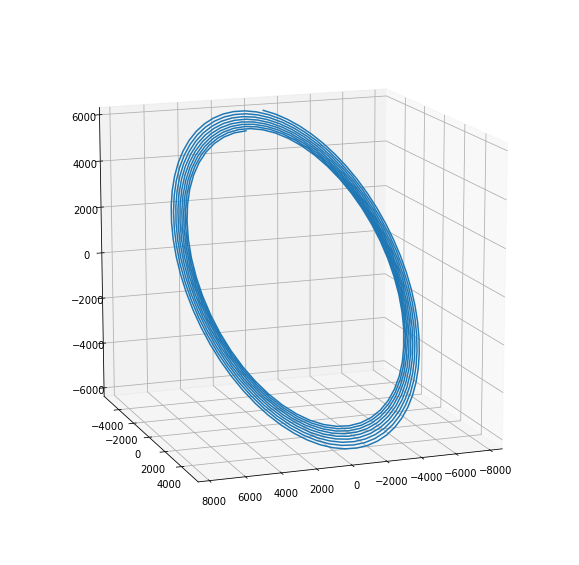

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(*res[:, :3].T)

ax.view_init(14, 70)

## Interactivity

This is the last time we used `scipy.integrate.ode` directly. Instead, we can now import a convenient function from poliastro:

In [11]:
from poliastro.twobody.propagation import cowell

In [12]:
def plot_iss(thrust=0.1, mass=2000.):
    r0, v0 = iss.rv()
    k = iss.attractor.k
    t = np.linspace(0, 10 * iss.period, 500).to(u.s).value
    u0 = state_to_vector(iss)

    res = np.zeros((t.size, 6))
    res[0] = u0

    accel = thrust / mass

    # Perform the whole integration
    r0 = r0.to(u.km).value
    v0 = v0.to(u.km / u.s).value
    k = k.to(u.km**3 / u.s**2).value
    ad = constant_accel_factory(accel)
    r, v = r0, v0
    for ii in range(1, len(t)):
        r, v = cowell(k, r, v, t[ii] - t[ii - 1], ad=ad)
        x, y, z = r
        vx, vy, vz = v
        res[ii] = [x, y, z, vx, vy, vz]

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlim(-20e3, 20e3)
    ax.set_ylim(-20e3, 20e3)
    ax.set_zlim(-20e3, 20e3)

    ax.view_init(14, 70)

    return ax.plot(*res[:, :3].T)

In [13]:
interact(plot_iss, thrust=(0.0, 0.2, 0.001), mass=fixed(2000.))

A Jupyter Widget

<function __main__.plot_iss>

## Error checking

In [14]:
rtol = 1e-13
full_periods = 2

In [15]:
u0 = state_to_vector(iss)
tf = ((2 * full_periods + 1) * iss.period / 2).to(u.s).value

u0, tf

(array([  8.59072560e+02,  -4.13720368e+03,   5.29556871e+03,
          7.37289205e+00,   2.08223573e+00,   4.39999794e-01]),
 13892.424252907538)

In [16]:
iss_f_kep = iss.propagate(tf * u.s, rtol=1e-18)

In [17]:
r0, v0 = iss.rv()
r, v = cowell(k, r0.to(u.km).value, v0.to(u.km / u.s).value, tf, rtol=rtol)

iss_f_num = Orbit.from_vectors(Earth, r * u.km, v * u.km / u.s, iss.epoch + tf * u.s)

In [18]:
iss_f_num.r, iss_f_kep.r

(<Quantity [ -835.92108005, 4151.60692532,-5303.60427969] km>,
 <Quantity [ -835.92108005, 4151.60692532,-5303.60427969] km>)

In [19]:
assert np.allclose(iss_f_num.r, iss_f_kep.r, rtol=rtol, atol=1e-08 * u.km)
assert np.allclose(iss_f_num.v, iss_f_kep.v, rtol=rtol, atol=1e-08 * u.km / u.s)

In [20]:
assert np.allclose(iss_f_num.a, iss_f_kep.a, rtol=rtol, atol=1e-08 * u.km)
assert np.allclose(iss_f_num.ecc, iss_f_kep.ecc, rtol=rtol)
assert np.allclose(iss_f_num.inc, iss_f_kep.inc, rtol=rtol, atol=1e-08 * u.rad)
assert np.allclose(iss_f_num.raan, iss_f_kep.raan, rtol=rtol, atol=1e-08 * u.rad)
assert np.allclose(iss_f_num.argp, iss_f_kep.argp, rtol=rtol, atol=1e-08 * u.rad)
assert np.allclose(iss_f_num.nu, iss_f_kep.nu, rtol=rtol, atol=1e-08 * u.rad)

Too bad I cannot access the internal state of the solver. I will have to do it in a blackbox way.

In [21]:
u0 = state_to_vector(iss)
full_periods = 4

tof_vector = np.linspace(0, ((2 * full_periods + 1) * iss.period / 2).to(u.s).value, num=100)
rtol_vector = np.logspace(-3, -12, num=30)

res_array = np.zeros((rtol_vector.size, tof_vector.size))
for jj, tof in enumerate(tof_vector):
    rf, vf = iss.propagate(tof * u.s, rtol=1e-12).rv()
    for ii, rtol in enumerate(rtol_vector):
        rr = ode(func_twobody).set_integrator('dop853', rtol=rtol, nsteps=1000)
        rr.set_initial_value(u0, 0.0)
        rr.set_f_params(k, constant_accel_factory(0.0))  # Zero acceleration

        rr.integrate(rr.t + tof)

        if rr.successful():
            uf = rr.y

            r, v = uf[:3] * u.km, uf[3:] * u.km / u.s

            res = max(norm((r - rf) / rf), norm((v - vf) / vf))
        else:
            res = np.nan

        res_array[ii, jj] = res

/home/juanlu/.miniconda36/envs/poliastro36/lib/python3.6/site-packages/scipy/integrate/_ode.py:1035: UserWarning: dop853: step size becomes too small
  self.messages.get(idid, 'Unexpected idid=%s' % idid))


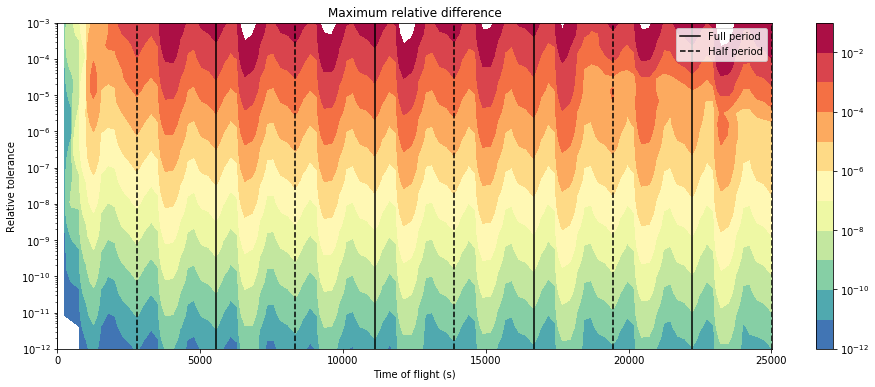

In [22]:
fig, ax = plt.subplots(figsize=(16, 6))

xx, yy = np.meshgrid(tof_vector, rtol_vector)

cs = ax.contourf(xx, yy, res_array, levels=np.logspace(-12, -1, num=12),
             locator=ticker.LogLocator(), cmap=plt.cm.Spectral_r)
fig.colorbar(cs)

for nn in range(full_periods + 1):
    lf = ax.axvline(nn * iss.period.to(u.s).value, color='k', ls='-')
    lh = ax.axvline((2 * nn + 1) * iss.period.to(u.s).value / 2, color='k', ls='--')

ax.set_yscale('log')

ax.set_xlabel("Time of flight (s)")
ax.set_ylabel("Relative tolerance")

ax.set_title("Maximum relative difference")

ax.legend((lf, lh), ("Full period", "Half period"))

## Numerical validation

According to [Edelbaum, 1961], a coplanar, semimajor axis change with tangent thrust is defined by:

$$\frac{\operatorname{d}\!a}{a_0} = 2 \frac{F}{m V_0}\operatorname{d}\!t, \qquad \frac{\Delta{V}}{V_0} = \frac{1}{2} \frac{\Delta{a}}{a_0}$$

So let's create a new circular orbit and perform the necessary checks, assuming constant mass and thrust (i.e. constant acceleration):

In [24]:
ss = Orbit.circular(Earth, 500 * u.km)
tof = 20 * ss.period

ad = constant_accel_factory(1e-7)

r0, v0 = ss.rv()
r, v = cowell(k, r0.to(u.km).value, v0.to(u.km / u.s).value,
              tof.to(u.s).value, ad=ad)

ss_final = Orbit.from_vectors(Earth, r * u.km, v * u.km / u.s, ss.epoch + rr.t * u.s)

In [25]:
da_a0 = (ss_final.a - ss.a) / ss.a
da_a0

<Quantity 2.9896208842009824e-06 km / m>

In [26]:
dv_v0 = abs(norm(ss_final.v) - norm(ss.v)) / norm(ss.v)
2 * dv_v0

<Quantity 0.002996053718832534>

In [27]:
np.allclose(da_a0, 2 * dv_v0, rtol=1e-2)

True

In [28]:
dv = abs(norm(ss_final.v) - norm(ss.v))
dv

<Quantity 0.011403891845299441 km / s>

In [29]:
accel_dt = accel * u.km / u.s**2 * (t[-1] - t[0]) * u.s
accel_dt

<Quantity 0.5556969701163016 km / s>

In [30]:
np.allclose(dv, accel_dt, rtol=1e-2, atol=1e-8 * u.km / u.s)

False

This means **we successfully validated the model against an extremely simple orbit transfer with approximate analytical solution**. Notice that the final eccentricity, as originally noticed by Edelbaum, is nonzero:

In [31]:
ss_final.ecc

<Quantity 6.662142824041997e-06>

## References

* [Edelbaum, 1961] "Propulsion requirements for controllable satellites"